In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /tmp/matplotlib-12jkqf1m because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
compute_device = torch.device('cuda')

In [3]:
torch.Tensor([1,2]).to(compute_device)

tensor([1., 2.], device='cuda:0')

In [4]:
class FullyConnectedRNN(nn.Module):
    def __init__(self, hidden_units, input_units = 2):
        super(FullyConnectedRNN, self).__init__()
        
        self.parameter_list = nn.ParameterList()
        
        self.hidden_units = hidden_units
        self.input_units = input_units
        
        self.W = nn.Parameter(torch.randn(self.hidden_units, self.hidden_units)).to(compute_device)
        self.Win = nn.Parameter(torch.randn(self.input_units, self.hidden_units)).to(compute_device)
        
        self.relu = nn.ReLU()
        
        self.parameter_list.append(self.W)
    
    def init_hidden_state(self):
        self.hidden_state = torch.zeros(self.hidden_units).to(compute_device)
    
    def forward(self, x):
        
        # solution 1: architectural - input-segregated populatons
        input_matrix = torch.ones(self.hidden_units).to(compute_device)
        input_matrix[:self.hidden_units//2] *= x[0]
        input_matrix[self.hidden_units//2:] *= x[1]
        
        # solution 2:
        input_state = torch.Tensor(x).to(compute_device)
        input_matrix = input_state @ self.Win
               
        preactivations = self.hidden_state @ self.W + input_matrix
        self.hidden_state = self.relu(preactivations)
        
        return preactivations, self.hidden_state.detach(), self.W

In [5]:
# FUNCTIONS
def generate_acceleration_and_velocity(samples, initial_velocity = 1):
    
    acceleration = np.around(np.random.normal(0,1, samples), 2)
    
    velocity = [initial_velocity]
    const = 0.1
    for i in range(acceleration.shape[0]):
        velocity.append(velocity[-1] + const*acceleration[i])
    
    return acceleration, velocity

def generate_variable_sine(samples, velocity):
    def get_freq_per_sample(rad_angle, dt):
        return 2 * np.pi * rad_angle * dt

    t = np.linspace(0, 1, samples)
    dt = t[1]-t[0]
    y = list()
    phi = 0
    for i in range(t.shape[0]):
        c = np.cos(phi)
        y.append(c)
        phi = phi + get_freq_per_sample(10*velocity[i], dt)
    return t, y

In [6]:
def generate_inputs(samples):
    acceleration, velocity = generate_acceleration_and_velocity(samples)
    t, sine_signal = generate_variable_sine(samples, velocity)
    return acceleration, sine_signal

In [7]:
SAMPLE_NUM = 1000
acceleration, velocity = generate_acceleration_and_velocity(SAMPLE_NUM)
t, sine_signal = generate_variable_sine(SAMPLE_NUM, velocity)

### Training

In [8]:
torch.cuda.is_available()

True

In [9]:
def L1_loss_function(x):
    return torch.mean(torch.abs(x))

In [10]:
model = FullyConnectedRNN(100)

learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
losses = []
train_outs = {}
samples = 10
INPUT_MULTIPLIER = 0.000001

for epoch in range(100):
    epoch_loss = torch.zeros(1, dtype=torch.float, requires_grad=True).to(compute_device)
    optimizer.zero_grad()
    
    train_outs[f'epoch{epoch}'] = {}
    
    acceleration, sine_signal = generate_inputs(samples)
    model.init_hidden_state()

    for t in range(len(acceleration)):
        preactivations, hidden_state, W = model([acceleration[t] * INPUT_MULTIPLIER, sine_signal[t] * INPUT_MULTIPLIER])
        # train_outs[f'epoch{epoch}']['preactivations'] = preactivations
        # train_outs[f'epoch{epoch}']['hidden_state'] = hidden_state
        # train_outs[f'epoch{epoch}']['W'] = W
        iteration_loss = L1_loss_function(preactivations)
        epoch_loss = epoch_loss + iteration_loss
        
        # if t in [0,100,500,999]:
        #     print(preactivations)
        #     print(hidden_state)
        #     print(W)

    epoch_loss.backward()
    optimizer.step()
    losses.append(epoch_loss.item())
    print(f'Epoch {epoch+1}, Loss: {epoch_loss.item():.4f}')

Epoch 1, Loss: 60.8135
Epoch 2, Loss: 66.4279
Epoch 3, Loss: 57.8008
Epoch 4, Loss: 60.7588
Epoch 5, Loss: 59.8194
Epoch 6, Loss: 77.1557
Epoch 7, Loss: 121.3158
Epoch 8, Loss: 59.2398
Epoch 9, Loss: 71.8369
Epoch 10, Loss: 86.4875
Epoch 11, Loss: 58.7087
Epoch 12, Loss: 65.1564
Epoch 13, Loss: 85.2095
Epoch 14, Loss: 97.5419
Epoch 15, Loss: 105.4479
Epoch 16, Loss: 72.1372
Epoch 17, Loss: 60.7835
Epoch 18, Loss: 55.0309
Epoch 19, Loss: 91.4994
Epoch 20, Loss: 71.0707
Epoch 21, Loss: 73.1899
Epoch 22, Loss: 65.1704
Epoch 23, Loss: 77.9003
Epoch 24, Loss: 108.8577
Epoch 25, Loss: 87.2359
Epoch 26, Loss: 63.0257
Epoch 27, Loss: 77.0361
Epoch 28, Loss: 70.9763
Epoch 29, Loss: 105.5712
Epoch 30, Loss: 71.4447
Epoch 31, Loss: 65.3230
Epoch 32, Loss: 83.3868
Epoch 33, Loss: 94.1633
Epoch 34, Loss: 77.7930
Epoch 35, Loss: 111.4954
Epoch 36, Loss: 62.0451
Epoch 37, Loss: 61.6128
Epoch 38, Loss: 73.1973
Epoch 39, Loss: 68.6968
Epoch 40, Loss: 104.6211
Epoch 41, Loss: 71.2214
Epoch 42, Loss: 139

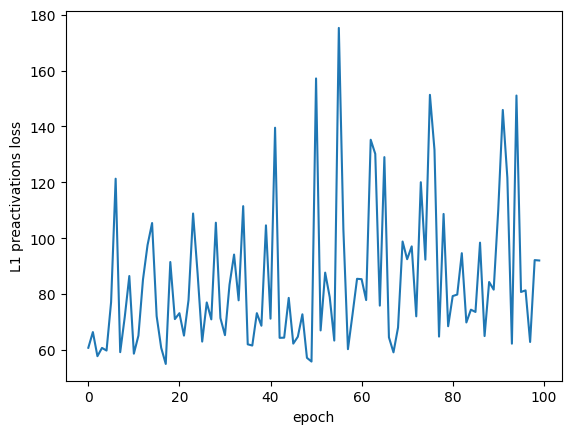

In [12]:
plt.plot(losses)
plt.ylabel('L1 preactivations loss')
plt.xlabel('epoch')
plt.show()